In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
set_global_policy('mixed_float16')

# Verify
print("Mixed precision policy:", tf.keras.mixed_precision.global_policy())


2.16.1
TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1
Mixed precision policy: <FloatDTypePolicy "mixed_float16">


## ⏳ Load the Data

In [2]:
augmentation=True

if not(augmentation):
    data = np.load('/kaggle/input/dataset/mars_for_students.npz')

    training_set = data["training_set"]
    X_train = training_set[:, 0]
    y_train = training_set[:, 1]
    
    X_test = data["test_set"]
    
else:
    data=np.load('/kaggle/input/datasetaugmented/mars_for_students_aug.npz')

    X_train=data['X_train']
    y_train=data['y_train']
    X_val=data['X_val']
    y_val=data['y_val']
    X_test=data['X_test']


print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (4000, 64, 128, 1)
Training y shape: (4000, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


### Dataset Creation

### Data exploration

In [ ]:
def display_color_mapped_image_continuous(image, n_colors=5):
    '''
    associates at every different class a different color
    Inputs:
        -image: contains the image to be processed
        -n_colors: contains the number of color with color the image
    Output:
        -colored_image: contains the image processed
    '''
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, n_colors))
    #print(colors)

    # Map the colors
    colored_image = colors[image.astype(int)]

    return colored_image

def plot_sample_images(X, mask, num_row):
    '''
    Plot 2*num_row images from X with their masks organizing them in subplots in the form num_row * 4
    Inputs:
        -X: vector that contains the images to be shown
        -mask: vecctor that contains the masks of the realtive images
        -num_row: number of rows that will be shown
    Outputs:
        None
    '''
    
    fig, axes = plt.subplots(num_row, 4,figsize=(30,3*num_row+10))
    iter=1
    for i in range(2*num_row):
        #plot the image
        index = np.random.randint(0,len(X))
        ax=plt.subplot(num_row,4,iter)
        ax.set_title(f"Image {index}")
        ax.imshow(X[index])

        iter=iter+1

        #plot the relative mask
        ax=plt.subplot(num_row,4,iter)
        ax.set_title(f"Mask {index}")
        colored_image = display_color_mapped_image_continuous(mask[index])
        ax.imshow(np.squeeze(colored_image))
        iter=iter+1
    plt.show()


In [ ]:
# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

We need to clean the dataset from the outlier like the image at the index 79 that contains an alien

In [ ]:
indecesAlien=[]

for i in range(max(y_train.shape)):
    if (y_train[i] == y_train[79]).all():
        indecesAlien.append(i)
        '''
        # eventual plot of the images that will be removed
        fig, axes = plt.subplots(1, 2,figsize=(16,4))
        ax=plt.subplot(1,2,1)
        ax.set_title(f"Image {i}")
        ax.imshow(X_train[i])
        
        ax=plt.subplot(1,2,2)
        ax.set_title(f"Mask {i}")
        colored_image = display_color_mapped_image_continuous(y_train[i])
        ax.imshow(np.squeeze(colored_image))
        plt.show()
        '''
        
X_train = np.delete(X_train, indecesAlien, axis=0)
y_train = np.delete(y_train, indecesAlien, axis=0)

In [ ]:
# Plot sample images from the training set
plot_sample_images(X_train, y_train, num_row=10)

## Preprocessing data

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=seed)

print(f"Shapes after splitting:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

## 🛠️ Train and Save the Model

In [3]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


### Building blocks

In [4]:
def basic_cnn_block(x, filters=32, kernel_size=3, padding='same',
                    downsample=True, activation='relu', stack=2, name='basic'):
    # Define a basic CNN block with Conv -> ReLU -> MaxPool pattern
    for i in range(stack):
        x = tfkl.SeparableConv2D(filters, kernel_size, padding=padding, name=f'{name}_conv_{i}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act_{i}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn_{i}')(x)

    # Add MaxPooling layer if downsample is True
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [5]:
def inception_module(x, filters_1x1=32, filters_3x3_reduce=48, filters_3x3=64,
                     filters_5x5_reduce=8, filters_5x5=26,
                     stack=2, name='inception', padding='same', activation='leaky_relu'):
    # Initialize lists to collect outputs from each branch
    outputs = []

    # Define a basic CNN block with Conv -> ReLU -> MaxPool pattern
    for i in range(stack):
        # 1x1 convolution
        conv_1 = tfkl.SeparableConv2D(filters_1x1, 1, padding=padding, name=f'{name}_conv_1x1_{i}')(x)
        conv_1 = tfkl.Activation(activation, name=f'{name}_act_1x1_{i}')(conv_1)
        conv_1 = tfkl.BatchNormalization(name=f'{name}_bn_1x1_{i}')(conv_1)
        outputs.append(conv_1)

        # 3x3 convolution
        conv_3 = tfkl.SeparableConv2D(filters_3x3_reduce, 1, padding=padding, name=f'{name}_conv_3x3_reduce_{i}')(x)
        conv_3 = tfkl.SeparableConv2D(filters_3x3, 3, padding=padding, name=f'{name}_conv_3x3_{i}')(conv_3)
        conv_3 = tfkl.Activation(activation, name=f'{name}_act_3x3_{i}')(conv_3)
        conv_3 = tfkl.BatchNormalization(name=f'{name}_bn_3x3_{i}')(conv_3)
        outputs.append(conv_3)

        # 5x5 convolution
        conv_5 = tfkl.SeparableConv2D(filters_5x5_reduce, 1, padding=padding, name=f'{name}_conv_5x5_reduce_{i}')(x)
        conv_5 = tfkl.SeparableConv2D(filters_5x5, 5, padding=padding, name=f'{name}_conv_5x5_{i}')(conv_5)
        conv_5 = tfkl.Activation(activation, name=f'{name}_act_5x5_{i}')(conv_5)
        conv_5 = tfkl.BatchNormalization(name=f'{name}_bn_5x5_{i}')(conv_5)
        outputs.append(conv_5)

        # Average Pooling
        avg_pool = tfkl.AveragePooling2D(3, strides=1, padding='same', name=f'{name}_avg_pool_{i}')(x)
        conv_avg = tfkl.SeparableConv2D(filters_1x1, 1, padding=padding, name=f'{name}_conv_avg_{i}')(avg_pool)
        conv_avg = tfkl.Activation(activation, name=f'{name}_act_avg_{i}')(conv_avg)
        conv_avg = tfkl.BatchNormalization(name=f'{name}_bn_avg_{i}')(conv_avg)
        outputs.append(conv_avg)

    # Concatenate outputs from all branches
    x = tfkl.Concatenate(name=f'{name}_concat')(outputs)

    return x

In [6]:
# Define the Residual block with configurable parameters
def residual_block(x, filters, kernel_size=3, padding='same',
                   downsample=False, activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection
        skip = x

        # First convolutional block with Batch Normalisation and activation
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [7]:
# Define the SENet block with configurable parameters
def senet_block(x, filters, kernel_size=3, padding='same',
                downsample=True, activation='relu', stack=2, name='senet'):

    for s in range(stack):
        # Main convolutional path
        x = tfkl.Conv2D(filters, kernel_size, padding=padding,
                        use_bias=False, name=f'{name}_conv_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act_{s}')(x)

        # Squeeze-and-Excitation (SE) module
        channels = x.shape[-1]

        # Squeeze step
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_squeeze_{s}')(x)

        # Excitation step
        se = tfkl.Dense(channels // 16, activation=activation, name=f'{name}_dense1_{s}')(se)
        se = tfkl.Dense(channels, activation='sigmoid', name=f'{name}_dense2_{s}')(se)

        # Scaling of the output with SE activation
        se = tfkl.Reshape((1, 1, channels))(se)
        x = tfkl.Multiply(name=f'{name}_scale_{s}')([x, se])

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [8]:
# Define the MobileNetV3 block with configurable parameters
def mobilenetv3_block(x, filters, kernel_size=3, padding='same',
                      downsample=True, activation='leaky_relu', stack=1, name='mobilev3'):

    # Define h-swish activation function
    def h_swish(x):
        return x * tf.nn.relu6(x + 3.0) / 6.0

    # Select activation function
    activation_fn = tf.nn.relu if activation == 'relu' else h_swish

    for s in range(stack):
        input_channels = x.shape[-1]
        residual = x

        # Set expansion factor based on channel dimensions
        expansion_factor = 1 if input_channels == filters else 6
        expanded_channels = input_channels * expansion_factor

        # Expansion phase
        if expansion_factor != 1:
            x = tfkl.Conv2D(expanded_channels, 1, padding=padding, use_bias=False, name=f'{name}_expand_{s}')(x)
            x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
            x = tfkl.Activation(activation_fn, name=f'{name}_act1_{s}')(x)

        # Depthwise convolution with optional downsampling
        stride = 2 if (downsample and s == 0) else 1
        x = tfkl.DepthwiseConv2D(kernel_size, strides=stride, padding=padding, use_bias=False, name=f'{name}_depthwise_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)
        x = tfkl.Activation(activation_fn, name=f'{name}_act2_{s}')(x)

        # Squeeze-and-Excitation module
        se_channels = max(1, expanded_channels // 4)
        se = tfkl.GlobalAveragePooling2D(name=f'{name}_se_pool_{s}')(x)
        se = tfkl.Reshape((1, 1, expanded_channels))(se)
        se = tfkl.Conv2D(se_channels, 1, activation='relu', name=f'{name}_se_reduce_{s}')(se)
        se = tfkl.Conv2D(expanded_channels, 1, activation='hard_sigmoid', name=f'{name}_se_expand_{s}')(se)
        x = tfkl.Multiply(name=f'{name}_se_excite_{s}')([x, se])

        # Projection phase to desired filter dimension
        x = tfkl.Conv2D(filters, 1, padding=padding, use_bias=False, name=f'{name}_project_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(x)

        # Add skip connection if applicable
        if stride == 1 and input_channels == filters:
            x = tfkl.Add(name=f'{name}_add_{s}')([residual, x])

    return x

In [9]:
def unet_block(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=2, name=''):

    x = input_tensor
    for i in range(stack):
        x = residual_block(x, filters, name=name+'conv'+str(i+1))
        # x = tfkl.SeparableConv2D(filters, kernel_size=3, padding='same', name=name+'conv'+str(i+1))(x)
        x = tfkl.BatchNormalization(name=name+'bn'+str(i+1))(x)
        x = tfkl.Activation(activation, name=name+'activation'+str(i+1))(x)

    return x

In [10]:
def dense_skip_pathway(x, encoder_outputs, filters, level, name, activation='leaky_relu'):
    """
    Implements the dense skip pathway (nested convolution blocks) for UNet++.
    """
    for j in range(level):
        if j == 0:
            x = tfkl.Concatenate(name=f"{name}_concat_{j}")([encoder_outputs[level-1], x])
        else:
            x = tfkl.Concatenate(name=f"{name}_concat_{j}")([encoder_outputs[level-1], x] + skip_nodes[j - 1])
        x = tfkl.Conv2D(filters, kernel_size=3, padding="same", activation=activation, name=f"{name}_conv_{j}")(x)
        skip_nodes.append(x)
    return x


### Model Creation

In [11]:
augmentation = tfk.Sequential([
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
        ], name='Augmentation')

In [12]:
# Modifica Matte

def create_model(input_shape=input_shape, num_classes=num_classes, seed=seed, depth=3, do_augmentation=False, augmentation=augmentation):
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")
    
    # Optional Data Augmentation
    x = input_layer
    if do_augmentation and augmentation:
        x = augmentation(x)
        x = tfkl.BatchNormalization()(x)
    
    # Matrix to store blocks (depth x depth)
    matrix = [[None for _ in range(depth)] for _ in range(depth)]
    
    # Downsampling Path (last row of the matrix)
    for level in range(depth):
        if level == 0:
            matrix[depth-1][0] = unet_block(x, filters=64, name=f"down_block_{level+1}_")
        elif level == depth - 1:
            bottleneck = tfkl.MaxPooling2D(pool_size=2)(matrix[depth-1][depth-2])
            bottleneck = unet_block(bottleneck, filters=512, name="bottleneck")
            matrix[depth-1][depth-1] = bottleneck
        else:
            down = tfkl.MaxPooling2D(pool_size=2)(matrix[depth-1][level-1])
            down = unet_block(down, filters=64 * (2 ** level), name=f"down_block_{level+1}_")
            matrix[depth-1][level] = down
    
    # Upsampling Path (remaining columns)
    skip_connections = [matrix[depth-1][i] for i in range(depth-1)]
    for col in range(depth - 1, 0, -1):
        # Ensure upsample dimensions match skip connection
        upsample = tfkl.Conv2DTranspose(
            filters=64 * (2 ** (col - 1)),
            kernel_size=2,
            strides=2,
            padding="same"
        )(matrix[depth-1][col])
        
        # Resize adjusted_upsample to match skip connection's spatial dimensions
        adjusted_upsample = tfkl.Conv2D(
            filters=skip_connections[col-1].shape[-1], 
            kernel_size=1,
            padding="same"
        )(upsample)
        
        # Add explicit resizing for spatial alignment
        adjusted_upsample = tfkl.Resizing(
            height=skip_connections[col-1].shape[1], 
            width=skip_connections[col-1].shape[2]
        )(adjusted_upsample)
        
        # Concatenate all connections
        combined = tfkl.Concatenate()([adjusted_upsample, skip_connections[col-1]])
        
        # Apply a residual block
        filters = 64 * (2 ** (col - 1))
        combined = unet_block(combined, filters=filters, name=f"up_block_{col}_")
        matrix[depth-1][col-1] = combined
    
    # Output layer
    output_layer = tfkl.Conv2D(
        filters=num_classes,
        kernel_size=1,
        activation="softmax",
        name="output_layer"
    )(matrix[depth-1][0])
    
    # Create and return the model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name="U-Net")
    return model


### Model compilation

In [13]:
model = create_model()

import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, Loss
from tensorflow.keras.utils import to_categorical

class EnsembleLoss(tf.keras.losses.Loss):
    def __init__(self, dice_weight=0.5, bce_weight=0.5, epsilon=1e-6):
        super(EnsembleLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce_loss = tf.keras.losses.CategoricalCrossentropy()  # BinaryCrossentropy for binary segmentation
        self.epsilon = epsilon

    def dice_loss(self, y_true, y_pred):
        # Ensure predictions and ground truth have the same shape
        y_true = tf.cast(y_true, y_pred.dtype)

        # Compute Dice loss per class and average
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])  # Sum over spatial dimensions
        prediction_sum = tf.reduce_sum(y_pred, axis=[1, 2])
        target_sum = tf.reduce_sum(y_true, axis=[1, 2])

        dice_coeff = (2. * intersection + self.epsilon) / (prediction_sum + target_sum + self.epsilon)
        dice_loss = 1 - tf.reduce_mean(dice_coeff)  # Average over classes
        return dice_loss

    def call(self, y_true, y_pred):
        # Calculate individual losses
        dice = self.dice_loss(y_true, y_pred)
        bce = self.bce_loss(y_true, y_pred)

        # Combine losses
        return self.dice_weight * dice + self.bce_weight * bce

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name="mean_iou")

model.compile(optimizer="adamW", loss="sparse_categorical_crossentropy", metrics=[mean_iou])
# model.compile(optimizer='adamW', loss=EnsembleLoss(dice_weight=0.7, bce_weight=0.3), metrics=[mean_iou])


model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        256 │ down_block_1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │          0 │ down_block_1_con… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │     36,928 │ down_block_1_con… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        256 │ down_block_1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        256 │ down_block_1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │          0 │ down_block_1_con… │
│ (Add)               │ 64)               │            │ down_block_1_con… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │          0 │ down_block_1_con… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │     36,928 │ down_block_1_con… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        256 │ down_block_1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │          0 │ down_block_1_con… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │     36,928 │ down_block_1_con… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │        256 │ down_block_1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │          0 │ down_block_1_con… │
│ (Add)               │ 64)               │            │ down_block_1_con… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block_1_conv1… │ (None, 64, 128,   │          0 │ down_block_1_con

 Total params: 20,606,661 (78.61 MB)

 Trainable params: 20,586,949 (78.53 MB)

 Non-trainable params: 19,712 (77.00 KB)

### Fit the model

In [14]:
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (64, 128, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")
        colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(np.squeeze(colored_image))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

patience = 25
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', 
                                             mode='max', 
                                             patience=patience, 
                                             restore_best_weights=True,
                                             verbose = 1)
viz_callback = VizCallback(np.expand_dims(X_val[0],axis=0), np.expand_dims(y_val[0],axis=0))
scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', 
                                            mode='max', 
                                            factor=0.1, 
                                            patience=patience-10, 
                                            abs=1e-5, 
                                            cooldown = 5,
                                            verbose = 1)

In [15]:
batch_size = 32
epochs = 500

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data= (X_val, y_val),
    # callbacks=[early_stopping, viz_callback, scheduler],
    callbacks=[early_stopping, scheduler],
    verbose=2
).history

Epoch 1/500


I0000 00:00:1733355264.547885      97 service.cc:145] XLA service 0x78aa28002270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733355264.547938      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733355309.386792      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_20__7', 1216 bytes spill stores, 1204 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16__6', 1580 bytes spill stores, 1624 bytes spill loads

I0000 00:00:1733355309.443153      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1733355352.193700      97 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00

125/125 - 126s - 1s/step - loss: 1.2451 - mean_iou: 0.2180 - val_loss: 11.8328 - val_mean_iou: 0.0069 - learning_rate: 0.0010
Epoch 2/500
125/125 - 42s - 339ms/step - loss: 0.9959 - mean_iou: 0.3210 - val_loss: 7.6558 - val_mean_iou: 0.0284 - learning_rate: 0.0010
Epoch 3/500
125/125 - 43s - 341ms/step - loss: 0.8997 - mean_iou: 0.3696 - val_loss: 3.0243 - val_mean_iou: 0.0573 - learning_rate: 0.0010
Epoch 4/500
125/125 - 43s - 341ms/step - loss: 0.8297 - mean_iou: 0.3922 - val_loss: 1.9728 - val_mean_iou: 0.1229 - learning_rate: 0.0010
Epoch 5/500
125/125 - 43s - 341ms/step - loss: 0.7869 - mean_iou: 0.4073 - val_loss: 1.5962 - val_mean_iou: 0.1599 - learning_rate: 0.0010
Epoch 6/500
125/125 - 43s - 341ms/step - loss: 0.7406 - mean_iou: 0.4235 - val_loss: 1.0633 - val_mean_iou: 0.2909 - learning_rate: 0.0010
Epoch 7/500
125/125 - 42s - 340ms/step - loss: 0.7173 - mean_iou: 0.4318 - val_loss: 2.3446 - val_mean_iou: 0.1263 - learning_rate: 0.0010
Epoch 8/500
125/125 - 43s - 341ms/step -

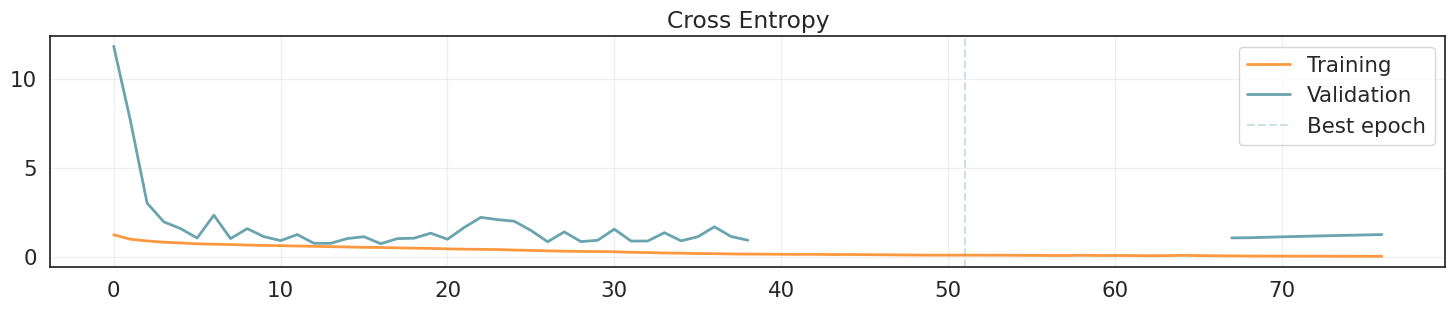

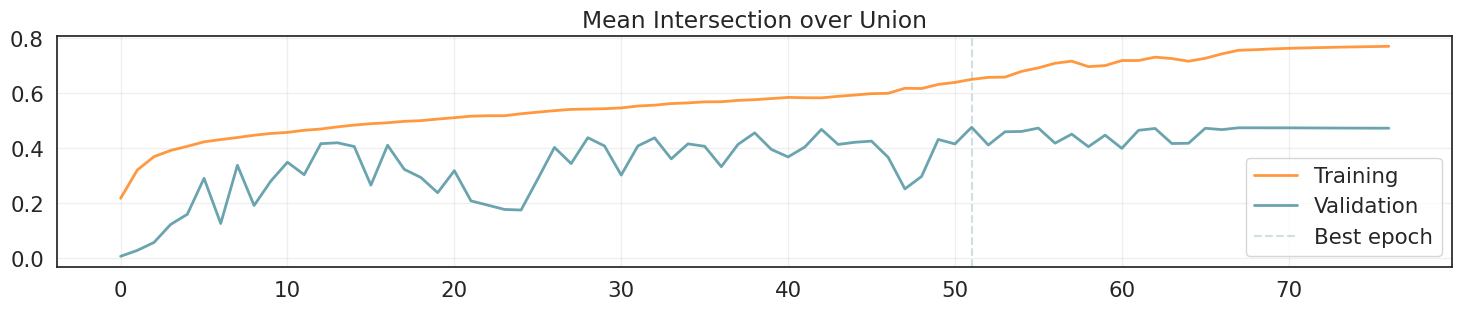

In [16]:
best_epoch = np.argmax(history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Save the model

In [17]:
import datetime 

timestep_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241205_002959.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

### Re-load the model

In [18]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [19]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241205_002959.keras


### Predict and save

In [20]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [21]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step
Predictions shape: (10022, 64, 128)


In [22]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)